# Enzyme kinetic fitting

Takes Excel files with specific activity measurements for enzymes (and corresponding mutants) and does a curve fitting to the Michaelis-Menten equation.

It works best with an Excel file that has the name of the corresponding mutant as a tab name (e.g. "WT" or "E9Q").

The table used should be in the format:

| substrate_1 | substrate_2 | specific activity 1 | specific activity 2 | specific activity 3 | mean | stdev |
|-------------|-------------|---------------------|---------------------|---------------------|------|-------|
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
| 20 | 300 | X | X | X | X | X |
| 40 | 300 | X | X | X | X | X |
| 60 | 300 | X | X | X | X | X |
| 80 | 300 | X | X | X | X | X |
| 100 | 300 | X | X | X | X | X |
| 130 | 300 | X | X | X | X | X |
| 0 |
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
| 100 | 50 | X | X | X | X | X |
| 100 | 100 | X | X | X | X | X |
| 100 | 200 | X | X | X | X | X |
| 100 | 300 | X | X | X | X | X |
| 100 | 400 | X | X | X | X | X |
| 100 | 500 | X | X | X | X | X |


In [1]:
# Import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import numpy as np

In [2]:
# Define the function that performs the kinetic fitting and plotting

def kinetic_fitting(mutant_name: str, filepath: str, mol_weight: np.number,
                    substrate1: str = "Substrate 1",
                    substrate2: str = "Substrate 2", label1: tuple=(75,0),
                    label2: tuple = (300,0), figsize: tuple = (12,8),
                    save: bool = False) -> None:
    """
    This function fits kinetic data for an enzyme to a Michaelis-Menten model
    and plots reaction rates versus substrate concentration, the corresponding
    fitted curve, and the calculated kinetic constants.

    Parameters:
    - mutant_name (str): The name or identifier of the mutant enzyme
                         found as the tab name in the Excel file.
    - filepath (str): The file path to the experimental data file.
    - mol_weight (np.number): The molecular weight of the enzyme in mg/µmole.
    - substrate1 (str, optional): Name of the first substrate (default: "Substrate 1").
    - substrate2 (str, optional): Name of the second substrate (default: "Substrate 2").
    - label1 (tuple, optional): Tuple specifying the initial position (x, y)
                                of label 1 on the plot for substrate 1 (default: (75, 0)).
    - label2 (tuple, optional): Tuple specifying the initial position (x, y)
                                of label 2 on the plot for substrate 2 (default: (300, 0)).
    - figsize (tuple, optional): Tuple specifying the figure size (default: (12, 8)).
    - save (bool, optional): If True, saves image to working directory.

    Returns:
    - None. Shows the plot

    Example usage:
    fitting_results = kinetic_fitting("filepath="mhMfr Kinetics.xlsx",
                                      mutant_name="WT", mol_weight=32.80175)

    Note:
    - You should have experimental data in the specified CSV file, formatted correctly for fitting.
    """

    # Read the Excel file into a dataframe and print dataframe
    excel = pd.ExcelFile(filepath)
    kinetics = pd.read_excel(excel,mutant_name)
    print("Measurements: \n \n" ,kinetics)

    # Split data into substrate concentrations, mean values and standard deviations
    xdata_sub1 = kinetics.loc[0:6,"substrate_1"]
    ydata_sub1 = kinetics.loc[0:6,"mean"]
    stdev_sub1 = kinetics.loc[0:6,"stdev"]
    xdata_sub2 = kinetics.loc[8:14,"substrate_2"]
    ydata_sub2 = kinetics.loc[8:14,"mean"]
    stdev_sub2 = kinetics.loc[8:14,"stdev"]

    #Specifies Michaelis-Menten equation for the curve fitting process
    def Michaelis_Menten(substrate, vmax, km):
        vi = vmax * substrate/(km + substrate)
        return vi

    # Fits the data for substrate 1 to Michaelis-Menten model
    popt_sub1, pcov_sub1 = curve_fit(Michaelis_Menten, xdata_sub1, ydata_sub1)
    vmax_sub1 = popt_sub1[0]
    km_sub1 = popt_sub1[1]
    #Specifies one standard deviation of the curve fitting process
    stdev_curve_sub1 = np.sqrt(np.diag(pcov_sub1))
    # Generates arrays to smooth out the curve for the latter plot
    xdata_sub1_smooth = np.linspace(np.min(xdata_sub1), np.max(xdata_sub1), 1000)
    fit_sub1_smooth = Michaelis_Menten(xdata_sub1_smooth, vmax_sub1, km_sub1)

    # Calculates kinetic constants and corresponding standard deviations
    # Creates array of Km values +/- stdev
    km_array_sub1 = np.array([km_sub1 - stdev_curve_sub1[1], km_sub1, km_sub1 + stdev_curve_sub1[1]])
    # Creates array of Vmax values +/- stdev
    vmax_array_sub1 = np.array([vmax_sub1 - stdev_curve_sub1[0], vmax_sub1, vmax_sub1 + stdev_curve_sub1[0]])
    # Calculates kcat [1/min]
    kcat_array_sub1 = vmax_array_sub1 * mol_weight
    # Calculates kcat/km [1/min*µmole]
    kcat_km_array_sub1 =  kcat_array_sub1 / km_array_sub1


    # Fits the data for substrate 2 to Michaelis-Menten model
    popt_sub2, pcov_sub2 = curve_fit(Michaelis_Menten, xdata_sub2, ydata_sub2)
    vmax_sub2 = popt_sub2[0]
    km_sub2 = popt_sub2[1]
    #Specifies standard deviation of the curve fitting process
    stdev_curve_sub2 = np.sqrt(np.diag(pcov_sub2))
    # Generates arrays to smooth out the curve for the latter plot
    xdata_sub2_smooth = np.linspace(np.min(xdata_sub2), np.max(xdata_sub2), 1000)
    fit_sub2_smooth = Michaelis_Menten(xdata_sub2_smooth, vmax_sub2, km_sub2)

    # Calculates kinetic constants and corresponding standard deviations
    # Creates array of Km values +/- stdev
    km_array_sub2 = np.array([km_sub2 - stdev_curve_sub2[1], km_sub2, km_sub2 + stdev_curve_sub2[1]])
    # Creates array of Vmax values +/- stdev
    vmax_array_sub2 = np.array([vmax_sub2 - stdev_curve_sub2[0], vmax_sub2, vmax_sub2 + stdev_curve_sub2[0]])
    # Calculates kcat [1/min]
    kcat_array_sub2 = vmax_array_sub2 * mol_weight
    # Calculates kcat/km [1/min*µmole]
    kcat_km_array_sub2 =  kcat_array_sub2 / km_array_sub2


    # Set up figure
    sns.set_theme(style = "ticks")
    fig, axes = plt.subplots(1,2, layout="constrained", figsize=figsize)

    # Plotting of curve fitting results for substrate 1
    axes[0].set_xlabel(substrate1 + " [µM]")
    axes[0].set_ylabel("Specific activity [U/mg]")
    axes[0].errorbar(xdata_sub1, ydata_sub1, yerr = stdev_sub1, fmt = "o", capsize = 3, zorder= 5)
    axes[0].plot(xdata_sub1_smooth, fit_sub1_smooth)
    axes[0].set_title(mutant_name)
    axes[0].annotate(f"$V_{{max}}$ = {vmax_sub1:.2f} +/- {stdev_curve_sub1[0]:.2f} \n"
                f"$K_m$ = {km_sub1:.2f} +/- {stdev_curve_sub1[1]:.2f} \n"
                f"$K_{{cat}}$ = {kcat_array_sub1.mean():.0f} +/- {kcat_array_sub1.std():.0f} \n"
                f"$K_{{cat}}/K_m$ = {kcat_km_array_sub1.mean():.2f} +/- {kcat_km_array_sub1.std():.2f} \n",
                xy = label1)

    # Plotting of curve fitting results for substrate 2
    axes[1].set_xlabel(substrate2 + " [µM]")
    axes[1].set_ylabel("Specific activity [U/mg]")
    axes[1].errorbar(xdata_sub2, ydata_sub2, yerr = stdev_sub2, fmt = "o", capsize = 3, zorder= 5)
    axes[1].plot(xdata_sub2_smooth, fit_sub2_smooth)
    axes[1].set_title(mutant_name)
    axes[1].annotate(f"$V_{{max}}$ = {vmax_sub2:.2f} +/- {stdev_curve_sub2[0]:.2f} \n"
                f"$K_m$ = {km_sub2:.0f} +/- {stdev_curve_sub2[1]:.0f} \n"
                f"$K_{{cat}}$ = {kcat_array_sub2.mean():.0f} +/- {kcat_array_sub2.std():.0f} \n"
                f"$K_{{cat}}/K_m$ = {kcat_km_array_sub2.mean():.2f} +/- {kcat_km_array_sub2.std():.2f} \n",
                xy = label2)

    print("\n \n Kinetic fitting: \n \n")
    if save:
      filename = mutant_name + ".png"
      plt.savefig(filename, dpi=300)
    plt.show()

Measurements: 
 
     substrate_1  substrate_2  specific activity 1  specific activity 2  \
0           0.0          0.0             0.000000             0.000000   
1          20.0        300.0             3.484216             2.561924   
2          40.0        300.0             4.201555             3.689170   
3          60.0        300.0             4.672949             5.062362   
4          80.0        300.0             4.198646             5.025067   
5         100.0        300.0             4.580616             4.873398   
6         130.0        300.0             5.062362             4.984479   
7           NaN          NaN                  NaN                  NaN   
8           0.0          0.0             0.000000             0.000000   
9         100.0         50.0             1.742108             1.127247   
10        100.0        100.0             1.947062             2.459447   
11        100.0        200.0             3.074309             3.381740   
12        100.0     

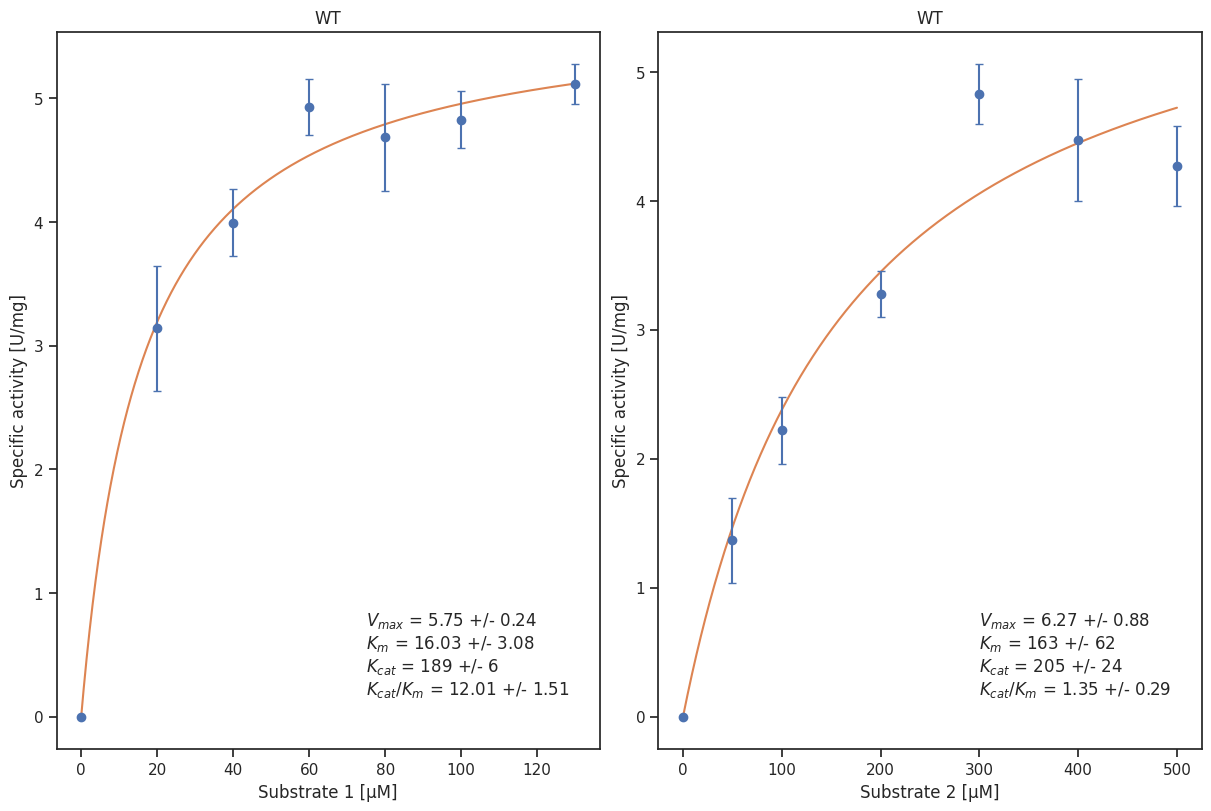

In [4]:
# Example execution
kinetic_fitting(filepath="mhMfr Kinetics.xlsx",
                mutant_name="WT",
                mol_weight=32.8)